In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape,MaxPooling2D,UpSampling2D,BatchNormalization
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import cv2

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data() 

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


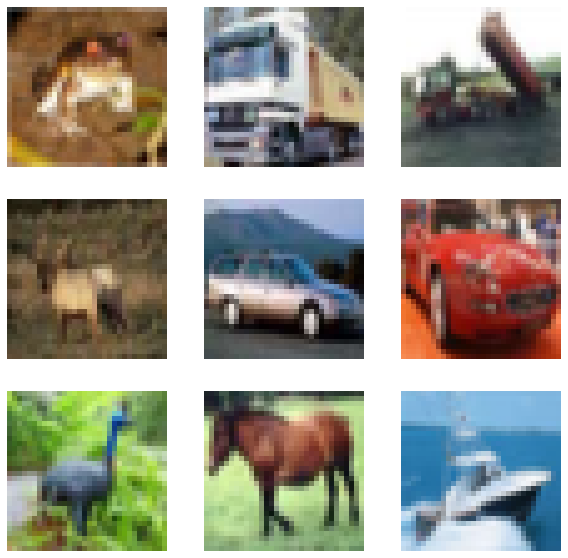

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i])
  plt.axis("off")

In [4]:
def add_gaussian_blur(data):
  dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
  return dst

def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise

def add_salt_pepper_noise(data, p=0.05):
  rows, columns, channels = data.shape
  output = np.zeros(data.shape, np.uint8)
  for i in range(rows):
    for j in range(columns):
      r = np.random.random()
      if r < p/2:
        output[i][j] = [0, 0, 0]
      elif r > p/2 and r <= p:
        output[i][j] = [255, 255, 255]
      else:
        output[i][j] = data[i][j]
  return output

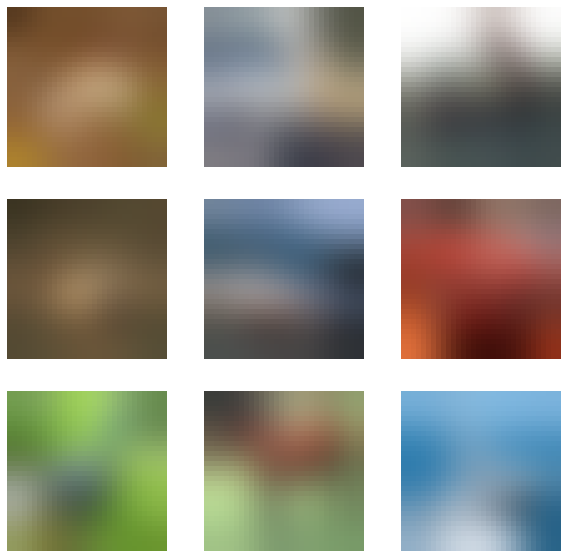

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(add_gaussian_blur(X_train[i]))
  plt.axis("off")

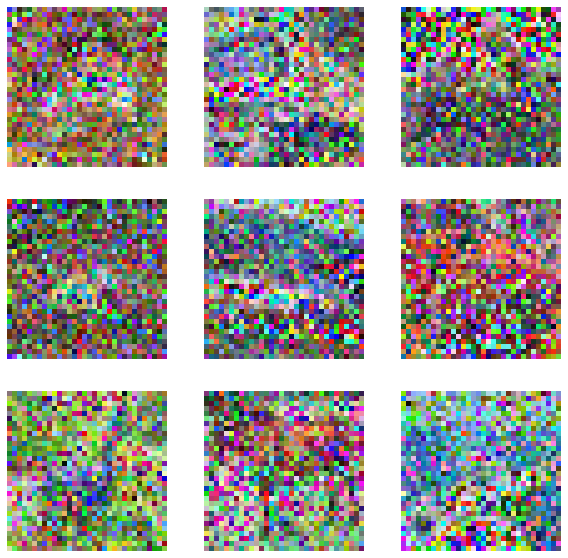

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(add_gaussian_noise(X_train[i]))
  plt.axis("off")

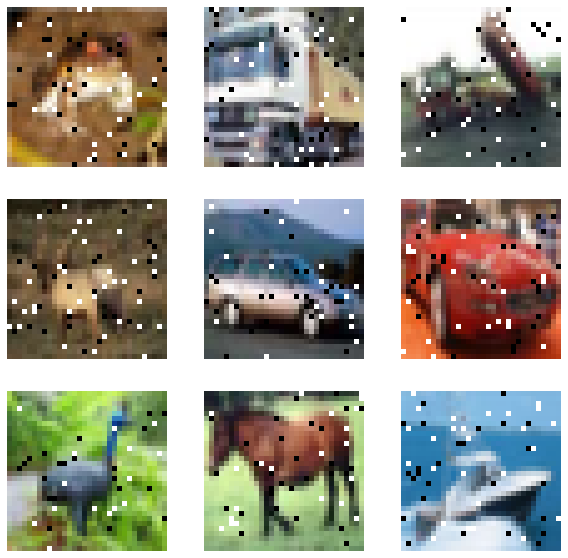

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(add_salt_pepper_noise(X_train[i]))
  plt.axis("off")

In [8]:
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    count+=1
  return np.array(output_data)

def add_gaussian_blur_to_dataset(data):
  count = 0 
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_blur(data[count]))
    count+=1
  return np.array(output_data)

train_data = X_train / 255.0
test_data = X_test / 255.0

gaussian_train_data = add_gaussian_to_dataset(train_data)
gaussian_test_data = add_gaussian_to_dataset(test_data)

gaussian_train_data = gaussian_train_data / 255.0 
gaussian_test_data = gaussian_test_data / 255.0 

In [9]:
def create_model():
  x = Input(shape=(32, 32, 3)) 

  # Encoder
  e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = BatchNormalization()(pool1)
  e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = BatchNormalization()(pool2)
  e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = MaxPooling2D((2, 2), padding='same')(e_conv3)


  # Decoder
  d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = UpSampling2D((2, 2))(d_conv1)
  d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2, 2))(d_conv2)
  d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
  up3 = UpSampling2D((2, 2))(d_conv3)
  r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

  model = Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model